Ce notebook à pour vocation de présenter sommairement l'impôt sur le revenu Français à l'aide du logiciel OpenFisca.  
  
Ce notebook est auto-exécutable, c'est à dire qu'à l'exception d'une installation [Jupyter](http://jupyter.org/install) avec un python 2.7, seule une connexion internet est nécessaire. L'ensemble des paquets utile à ce notebook seront téléchargés automatiquement.  


<b><font style="font-size:30px" color='red'>Attention</font> : <b><font style="font-size:30px">Des commandes pip sont exécutées via bash et vont automatiquement installer des packages `python` qui pourraient interagir avec votre installation actuelle. </font>
    
Si vous avez des projets `python` ayant des dépendances avec certains de ces packages veuillez considérer l'exécution de ce notebook <u>dans un environnement virtuel tel que [pew](https://github.com/berdario/pew#usage) ou [venv](https://docs.python.org/3/library/venv.html#module-venv).

1. [À propos du système socio-fiscal Français (et d'OpenFisca).](#%C3%80-propos-du-syst%C3%A8me-socio-fiscal-Fran%C3%A7ais-et-d'OpenFisca)  
2. [L'impôt sur le revenu français en théorie](#L'impôt-sur-le-revenu-français-en-théorie)
  2. [ Le barème en taux marginaux Français](#Le-barème-en-taux-marginaux-Français)  
    1. [Le barème implicite](#Le-barème-implicite)  
    2. [Calcul de l'impôt à partir du barème](#Calcul-de-l'impôt-à-partir-du-barème)   
  3. [La taxation commune en France](La-taxation-commune-en-France)  
    1.[Nombre de parts fiscales en fonction de la composition familiale](#Nombre-de-parts-fiscales-en-fonction-de-la-composition-familiale)
3. [L'impôt sur le revenu français en pratique](#L'impôt-sur-le-revenu-français-en-pratique)  
  1. [Le barème en taux marginal](#Le-barème-en-taux-marginal)  
  2. [La decote](#La-decote)  
  3. [Taux marginal effectif](#Taux-marginal-effectif)  
  4. [Perte-fiscale-au-mariage](#Perte-fiscale-au-mariage)
4. [Le plafond du quotient familial](#Le-plafond-du-quotient-familial)

### Installation des packages nécessaires à l'exécution du notebook.

In [109]:
%%capture #prevent output from printing
!pip install openfisca-france
!pip install matplotlib
!pip install mpld3
!pip install pandas==0.20.2 #A bug in pip prevent from importing further version
!pip install seaborn

UsageError: unrecognized arguments: output from printing


### Import des packages que nous allons utiliser au cours de ce notebook

In [3]:
%matplotlib inline
from __future__ import division

In [4]:
import matplotlib.pyplot as plt, mpld3
from matplotlib.ticker import FuncFormatter
from mpld3 import plugins
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 250)
pd.set_option('precision', 0)

# À propos du système socio-fiscal Français et d'OpenFisca

Le système socio-fiscal français pris dans une définition très large pourrait être défini par l'ensemble des règles émanant de la puissance étatique impliquant des transferts (pouvant être direct ou indirect, sous forme monétaire ou en nature) entre les différents citoyens.  
En ce sens le système socio-fiscal français est extrèmement complexe et large. 
Cela inclus évidemment les aides sociales tel que le RSA, les allocations familiales, etc. 
Cela inclu également toutes les taxes indirectes tels ques la TVA ([Taxe tampon](https://fr.wikipedia.org/wiki/Taxe_rose#Notion_de_taxe_tampon)), ou les droits d'ascise ([Taxe SODA](https://publications.banque-france.fr/publications-economiques-et-financieres-documents-de-travail/limpact-de-la-taxe-soda-sur-les-prix-des-boissons-non-alcoolisees-une-etude-sur-donnees).
Cela va également de la gratuité des transports en commun ou d'accès à la bibliothèque pour les chômeurs (ce qui constitue des droits connexes locaux), à la protection maladie universelle (PUMA), l'assistance juridictionnelle ou aux bourses CNOUS (droits connexes nationnaux).

La complexité et le nombre de règles impliquées fait qu'un modèle centralisé et fermé sera toujours incomplet pour déterminer l'effet des politiques publiques sur les transferts entre citoyens. OpenFisca permet déjà de prendre en compte une grande partie des règles du système soci-fiscal français ([OpenFisca-France](https://github.com/openfisca/openfisca-france)), mais également la taxation indirecte [Openfisca-france-indirect-taxation](https://github.com/openfisca/openfisca-france-indirect-taxation), mais également les aides locales de certaines villes comme [Paris](https://github.com/betagouv/openfisca-paris), Pau, [Rennes](), Brest, la région du Loiret, etc.

Sur l'ensemble de ces allons nous concentrer sur une prestation redistributive marginale au sein de ce système qui concerne environ 75 milliards d'euros parmis les 1200 milliards d'euros de recettes publiques de la France, soit environ 6,35% du budget de l'État (au sens large).

La version d'OpenFisca que vous utilisez est-celle qui s'affiche ci-dessous:

In [52]:
!pip show openfisca_france

Name: OpenFisca-France
Version: 21.8.3
Summary: French tax and benefit system for OpenFisca
Home-page: https://github.com/openfisca/openfisca-france
Author: OpenFisca Team
Author-email: contact@openfisca.fr
License: http://www.fsf.org/licensing/licenses/agpl-3.0.html
Location: /Users/adrienpacifico/.local/share/virtualenvs/OpenFisca_17_04_2018/lib/python2.7/site-packages
Requires: requests, OpenFisca-Core
Required-by: 


Nous importons le package d'OpenFisca-France ainsi que certains sous-packages spécifiques nécessaire à l'exécution du notebook.

In [53]:
#Specific usage imports
from openfisca_core import periods, rates
import openfisca_france

Nous importons le `tax-benefit-system` et créons des fonctions afin de simuler des scénarios (ou cas types) qui nous servirons pour les simulations.

In [54]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

In [55]:
ax_variable_max = 280000
count = 1000

year_lag_max = 4
def make_scenario(couple = True, mar_pacs = True, nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count,count_span = None, age = 12, salaire_de_base_conjoint = 0):
    if mar_pacs: assert couple == True
    if count is None: count =  (ax_variable_max - ax_variable_min)/count_span #Fais une simulation par tranche de 10 euros brut
    
    enfant = [dict(age = age)]
    enfants = enfant * nombre_enfants
    
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [dict(count = count, 
                  min = ax_variable_min,
                  max = ax_variable_max,
                  name = axes_variable,
                  period = year-fill_lag) for fill_lag in range(year_lag_max)]
            ],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = u"pacse",
            ) if mar_pacs else dict(
            age = 40,
            ppe_du_sa = 6020, statut_marital = u"celibataire" 
            ),
        parent2 = dict(age = 40,ppe_du_sa = 6020,statut_marital = "pacse", salaire_de_base = salaire_de_base_conjoint) if mar_pacs else (dict(age = 40,ppe_du_sa = 6020,salaire_de_base = salaire_de_base_conjoint, statut_marital = u"celibataire") if couple == True else None) ,
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = "locataire_vide",
            depcom = 13012,
            ),
        foyer_fiscal = dict(
            f7ea = nombre_enfants * ((age<15) * age>=11), #Nombre enfants à charge poursuivants leurs études : collège
            f7ec = nombre_enfants * ((age<19) * age>=15), #Nombre enfants à charge poursuivants leurs études : lycée
            f7ef = nombre_enfants * ((age<26) * age>=19), #Nombre enfants à charge poursuivants leurs études : Enseignement supérieur
            caseT = False if couple == True else True * (nombre_enfants>0)# Warning ! TODO: mieux gérer, à priori pose pas de problème si True avec un couple marié...
            ),
        )

    if (couple == True) and (mar_pacs==False):
        test_case = scenario.test_case
        test_case["foyers_fiscaux"][0]['declarants']  = ['ind0']
        test_case["foyers_fiscaux"].append({'declarants': ['ind1'],'id': 1,'caseT': False })
        scenario.test_case = test_case
        return scenario
    else:
        return scenario
        
        


# L'impôt sur le revenu français en théorie

## Le barème en taux marginaux Français

In [56]:
start_year = 2011 ; stop_year = 2019
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame(index = range(40), columns= pd.MultiIndex.from_product([range(start_year,stop_year), ["Rate", "Threshold"]]))
for year in range(start_year, stop_year):
    parameters = empty_simulation.parameters_at(periods.period(year))
    df.loc[:,(year,"Rate")] = pd.Series(parameters.impot_revenu.bareme.rates)
    df.loc[:,(year,"Threshold")] = pd.Series(parameters.impot_revenu.bareme.thresholds)
    pd.options.display.float_format = '{:20,.10g}'.format

df_piecewize_scheame = df
df_piecewize_scheame.dropna(axis=0, how='all', inplace = True) ; df_piecewize_scheame.replace(np.nan, "")

2011                                      2012  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   
5                                                           0.45   

                                       2013                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                5,963                0.055                6,011   
2               11,896                 0.14               11,991   
3               26,420                  0.3               26,631   
4               70,830                 0.41               71,397   
5              150,000                 0.45              151,200   

                  2014                                      2015  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                 0.14                9,690                 0.14   
2                  0.3               26,764                  0.3   
3                 0.41               71,754                 0.41   
4                 0.45              151,956                 0.45   
5                                                                  

                                       2016                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                9,700                 0.14                9,710   
2               26,791                  0.3               26,818   
3               71,826                 0.41               71,898   
4              152,108                 0.45              152,260   
5                                                                  

                  2017                                      2018  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                 0.14                9,710                 0.14   
2                  0.3               26,818                  0.3   
3                 0.41               71,898                 0.41   
4                 0.45              152,260                 0.45   
5                                                                  

                        
             Threshold  
0                    0  
1                9,710  
2               26,818  
3               71,898  
4              152,260  
5

La table ci-dessus représente le __barème fiscal en taux marginaux__ de la france pour la période 2011-2014.  
OpenFisca fonctionne en année revenu, c'est à dire que le barème affiché pour une année N correspond au barème appliqué sur les revenus de cette même année N.  
Le barème de l'impôt sur le revenu 2014, correspond donc au barème 2013 dans OpenFisca.  
Grace aux [barèmes IPP](https://www.ipp.eu/outils/baremes-ipp/) contenu dans OpenFisca il est possible en modifiant la valeur de start_year de regarder la valeur de ces taux depuis l'année 1945.

### Le barème implicite

Mais il faut faire attention, certains méchanismes fiscaux comme la *contribution exceptionnelle sur les hauts revenus*, ou *la décote* ajoute des __tranches implicites__ au barème de l'impôt qui ne respectent pas totalement la logique du quotient familial.

In [57]:
start_year = 2010 ; stop_year = 2019
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame(index = range(40), columns= pd.MultiIndex.from_product([range(start_year,stop_year), ["Rate", "Threshold"]]))
df_cehr = df.copy()
for year in range(start_year, stop_year):
    parameters = empty_simulation.parameters_at(periods.period(year))
    thresholds = np.array(parameters.impot_revenu.bareme.thresholds)
    thresholds_with_cehr = np.append(thresholds, parameters.impot_revenu.cehr.thresholds[1:]) #TODO: faire ça proprement, ajouter la décote
    
    rates = np.array(parameters.impot_revenu.bareme.rates)
    rates_with_cehr = np.append(rates, rates[-1]+parameters.impot_revenu.cehr.rates[1:])
    df_cehr.loc[:,(year,"Rate")] = pd.Series(rates_with_cehr)
    df_cehr.loc[:,(year,"Threshold")] = pd.Series(thresholds_with_cehr)
    pd.options.display.float_format = '{:20,.10g}'.format

df_cehr.dropna(axis=0, how='all', inplace = True) ; df_cehr.replace(np.nan, "")

2010                                      2011  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   
5                                                           0.44   
6                                                           0.45   
7                                                                  

                                       2012                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                5,963                0.055                5,963   
2               11,896                 0.14               11,896   
3               26,420                  0.3               26,420   
4               70,830                 0.41               70,830   
5              250,000                 0.45              150,000   
6              500,000                 0.48              250,000   
7                                      0.49              500,000   

                  2013                                      2014  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                6,011                 0.14   
2                 0.14               11,991                  0.3   
3                  0.3               26,631                 0.41   
4                 0.41               71,397                 0.45   
5                 0.45              151,200                 0.48   
6                 0.48              250,000                 0.49   
7                 0.49              500,000                        

                                       2015                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                9,690                 0.14                9,700   
2               26,764                  0.3               26,791   
3               71,754                 0.41               71,826   
4              151,956                 0.45              152,108   
5              250,000                 0.48              250,000   
6              500,000                 0.49              500,000   
7                                                                  

                  2016                                      2017  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                 0.14                9,710                 0.14   
2                  0.3               26,818                  0.3   
3                 0.41               71,898                 0.41   
4                 0.45              152,260                 0.45   
5                 0.48              250,000                 0.48   
6                 0.49              500,000                 0.49   
7                                                                  

                                       2018                       
             Threshold                 Rate            Threshold  
0                    0                    0                    0  
1                9,710                 0.14                9,710  
2               26,818                  0.3               26,818  
3               71,898                 0.41               71,898  
4              152,260                 0.45              152,260  
5              250,000                 0.48              250,000  
6              500,000                 0.49              500,000  
7

## Calcul de l'impôt à partir du barème


TODO

A piecewize linear tax scheme is defined as : 1: A sequence of (usually) increasing marginal tax rate,



<h1><center>
   </center></h1>
$$0<m_0 <m_1 <...<m_p$$ 

$$0= \beta_0<\beta_1< ... < \beta_n  $$


If $y \in [\beta_k,\beta_{k+1}]$, then the tax liability is :
$$s(y)=   \sum_{j \leq k-1} mj(\beta{j+1} − \beta{j})+m_k(y−\beta_j)$$


(Formalisation d'un barème par morceaux prise dans P.J. "Lambert The distribution and redistribution of income", third edition P.181)

## La taxation commune en France

En France les couples sous union civile (i.e. soit mariés, soit pacés), font normalement l'objet d'une imposition commune de leurs revenu.  

Cette imposition commune consiste à :  

1. Regrouper les revenus de tout les individus du foyer fiscal (enfants et autre personnes à charges incluses).
2. Diviser ce revenu par le nombre de parts fiscales (voir section suivante).
3. Appliquer le barème linéaire par morceaux de l'impôt sur le revenu.
4. Remultiplier ce résultat par le nombre de parts fiscales



 

Formellement:  
<h1><center>$T(\frac{\sum{y_i}}{\text{Parts Fiscales}}) \times \text{Parts Fiscales} $  </center></h1>
Où $T()$ est la fonction linéaire par morceaux de l'impôt sur le revenu et $y_i$ est le revenu d'un individu i appartenant au foyer fiscal.

Le système amenant à diviser le revenu par le nombre de parts fiscales avant d'y appliquer le barème est appelé système du quotient familial. 
Il comporte une notion de sacrifice égal, c'est à dire qu'il suit une forme de logique proche des [échelles d'équivalences]().

Le revenu divisé par le nombre de parts fiscales est appelé par l'administration le revenu mis au quotient familial, ou quotient familial. Certains économistes parlent [de revenu equivalent](https://www.ccomptes.fr/sites/default/files/EzPublish/20150204-rapport-particulier-Bargain.pdf) pour faire référence au rapport aux échelles d'équivalences impliqué par l'impôt sur le revenu. D'autres parlent [d'échelles d'équivalences politiques](https://www.ofce.sciences-po.fr/pdf/dtravail/WP2015-16.pdf).

## Nombre de parts fiscales en fonction de la composition familiale

In [59]:
simulation_dict_couple_union_libre = dict()
for nb_enf in range(0,6):
    simulation_dict_couple_union_libre[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_couple_union_libre[nb_enf][year] = make_scenario(couple = True,mar_pacs=False,nombre_enfants=nb_enf,year = year, count= 1).new_simulation()
simulation_dict_couple_mar_pacs = dict()
for nb_enf in range(0,6):
    simulation_dict_couple_mar_pacs[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_couple_mar_pacs[nb_enf][year] = make_scenario(couple = True,mar_pacs=True,nombre_enfants=nb_enf,year = year, count= 1).new_simulation()
simulation_dict_single = dict()
for nb_enf in range(0,6):
    simulation_dict_single[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_single[nb_enf][year] = make_scenario(couple = False, mar_pacs=False, nombre_enfants=nb_enf,year = year, count=1).new_simulation()

In [60]:
df = pd.DataFrame(index = range(6))
for nb_enf in range(0, 6):
    df.loc[nb_enf,u"En couple(marié ou pacsé)"] = simulation_dict_couple_mar_pacs[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    df.loc[nb_enf,u"Union libre"] = simulation_dict_couple_union_libre[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    df.loc[nb_enf,u"Célibataire"] = simulation_dict_single[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    pd.options.display.float_format = '{:20,.10g}'.format
    df.index.name = "Enfants"

In [61]:
df

,En couple(marié ou pacsé),Union libre,Célibataire
Enfants,,,
0,2,1,1
1,2.5,1.5,2
2,3,2,2.5
3,4,3,3.5
4,5,4,4.5
5,6,5,5.5


La table ci-dessus montre le nombre de part fiscale pour un foyer fiscal pour un couple sous union-civile, pour un célibataire (au sens de l'impôt) vivant en couple, et pour un célibataire en fonction du nombre d'enfants dans le foyer fiscal. 

Il existe d'autres situations fiscales particulières (parents ou grands parents habitant sous le même toit, enfants handicapés, etc) pouvant modifier le nombre de parts fiscales.



##### Parts fiscales par ménage

Cependant un couple qui n'est pas sous union civile est constitué de deux foyers fiscaux, si on somme les parts de chaque foyer fiscal sur le ménage, on obtient le tableau suivant.

In [62]:

year = 2016
df = pd.DataFrame(index = range(6))
for nb_enf in range(0, 6):
    for simul_name, simulation_by_child_by_year in {u"En couple(marié ou pacsé)":simulation_dict_couple_mar_pacs,
                                  u"Union libre":simulation_dict_couple_union_libre,
                                  u"Célibataire":simulation_dict_single}.iteritems():
        simul = simulation_by_child_by_year[nb_enf][2015]
        nbptr = simul.calculate("nbptr", period = "2015")
        projected_nbptr =  simul.foyer_fiscal.project_on_first_person(nbptr)
        summed_over_menage_nbptr = simul.menage.sum(projected_nbptr)
        df.loc[nb_enf,simul_name] = summed_over_menage_nbptr
    pd.options.display.float_format = '{:20,.10g}'.format
    #df[year]["Rates"] = parameters.impot_revenu.bareme.rates
    df.index.name = "Enfants"

In [63]:
df

,Célibataire,En couple(marié ou pacsé),Union libre
Enfants,,,
0,1,2,2
1,2,2.5,2.5
2,2.5,3,3
3,3.5,4,4
4,4.5,5,5
5,5.5,6,6


On a le même nombre de parts fiscales sur le ménage entre un couple marié et un couple en union libre. Mais ceci ne vaut que si l'on met tout les enfants dans le même foyer fiscal. À cause de la part supplémentaire (au lieu de la demie-part) à partir du 3ème enfant, un ménage peut avoir plus ou moins de parts fiscales en fonction du choix d'allocation des enfants entre les deux foyers fiscaux.  

TODO: Faire le tableau Nombre de parts en fonction de l'alloction pour un couple libre.
    

# L'impôt sur le revenu français en pratique

## Le barème en taux marginal

On va regarder dans un premier temps l'action du barème de l'impôt sur le revenu d'un célibataire, pour cela on lance une simulation en faisant varier le montant du salaire pour un célibataire.

In [64]:
simulation_no_child = make_scenario(couple = False, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000).new_simulation()

In [65]:
salaire_imposable = simulation_no_child.calculate_add("salaire_imposable", period = 2016)
rni = simulation_no_child.calculate_add("rni", period = 2016)
impot_brut = simulation_no_child.calculate("ir_brut", period = 2016)

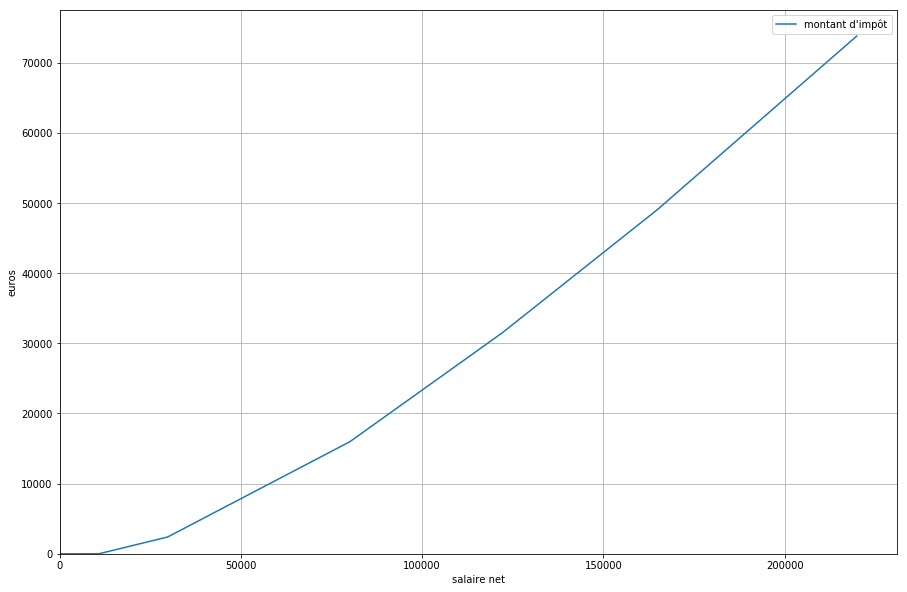

In [66]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(salaire_imposable, impot_brut, label = u"montant d'impôt")
plt.legend(); plt.xlabel("salaire net"); plt.ylabel("euros"); plt.xlim(0); plt.ylim(0); plt.grid()

In [67]:
print salaire_imposable[300]
print simulation_no_child.calculate_add("rfr", period = 2016)[300]
print impot_brut[300] #TODO: l'impôt est faux, sur le simulateur DgFIP j'obtiens 10871 pour l'IR 2017 sur les revenus 2016 en remplissant uniquement 1AJ et la date de naissance.

61235.703
55111.703
10883.23


In [68]:
from openfisca_core import rates

Le graphs ci-dessus montre le montant qui est payé en euros pour un salaire net donné.

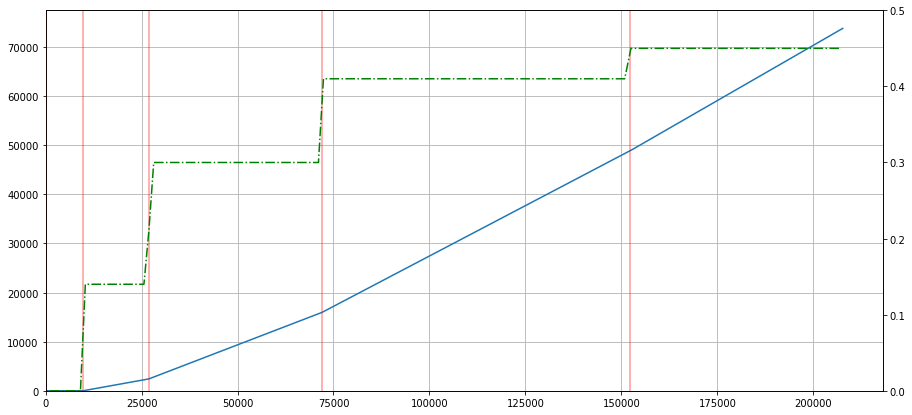

In [69]:
fig = plt.figure(figsize=(15,7))
smooth = 7
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        impot_brut)
ax2.plot(rni[1::smooth],
        1-rates.marginal_rate(
                           impot_brut,rni)[::smooth], linestyle = "-.", color = "g")
for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5); ax.grid()



(0, 0.5)

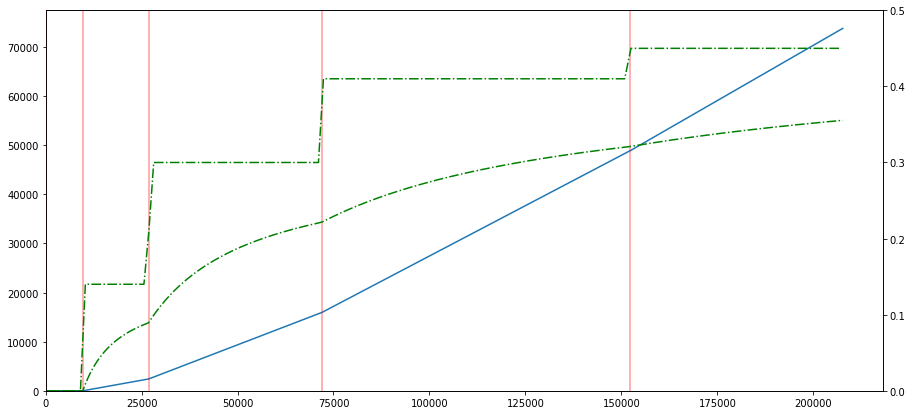

In [70]:
fig = plt.figure(figsize=(15,7))
smooth = 7
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        impot_brut)
ax2.plot(rni,
        1-rates.average_rate(
                           impot_brut,rni), linestyle = "-.", color = "g")
ax2.plot(rni[1::smooth],
        1-rates.marginal_rate(
                           impot_brut,rni)[::smooth], linestyle = "-.", color = "g")
for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5)



### La decote

La décote est un méchanisme fiscal qui vise à exonhérer d'impôt une grande partie de la population. Mais elle introduit une tranche fiscale implicite égale à deux fois le taux marginal de la première tranche, ce qui mêne une grande partie des français fait en fait face à un barème de l'impôt sur le revenu régressif plutôt que progressif...

In [71]:
decote_gain_fiscal = simulation_no_child.calculate("decote_gain_fiscal", year)

(8000, 24000)

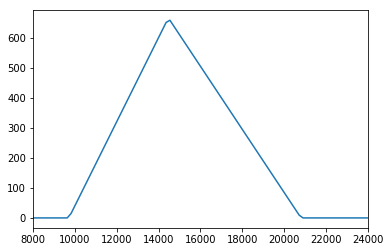

In [72]:
plt.figure()
plt.plot(rni,decote_gain_fiscal); plt.xlim(8000,24000)

In [73]:
impot_total_sur_le_revenu = -simulation_no_child.calculate("irpp", 2016)

(0, 0.5)

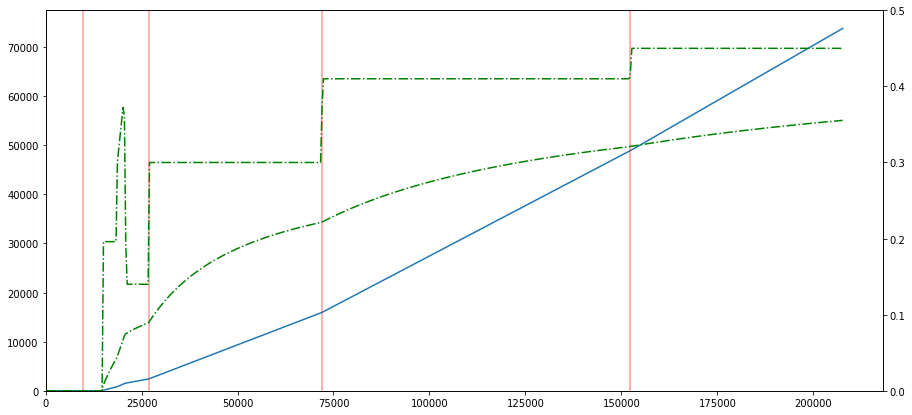

In [75]:
fig = plt.figure(figsize=(15,7))
smooth = 2
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        impot_total_sur_le_revenu)
ax2.plot(rni,
        1-rates.average_rate(
                           impot_total_sur_le_revenu,rni), linestyle = "-.", color = "g")
ax2.plot(rni[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,rni)[::smooth], linestyle = "-.", color = "g")
for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5)

### Taux marginal effectif

Les revenus nets bénéficient d'une série de potentiels abbatements qui vont constituer la base taxable.  
Le principal•aux sont l'abbatement de 10% dit pour frais professionel (ou le choix d'être au frais réels (case 1AK).

Cela conduit à des taux effectifs de taxations différent des taux affichés dans le barème de l'impôt sur le revenu.

In [76]:
salaire_net = simulation_no_child.calculate_add("salaire_net", 2016)
salaire_de_base = simulation_no_child.calculate_add("salaire_de_base", 2016)
salaire_super_brut = simulation_no_child.calculate_add("salaire_super_brut", 2016)
revenu_disponible = simulation_no_child.calculate_add("revenu_disponible", 2016)


Text(0,0.5,'Euros')

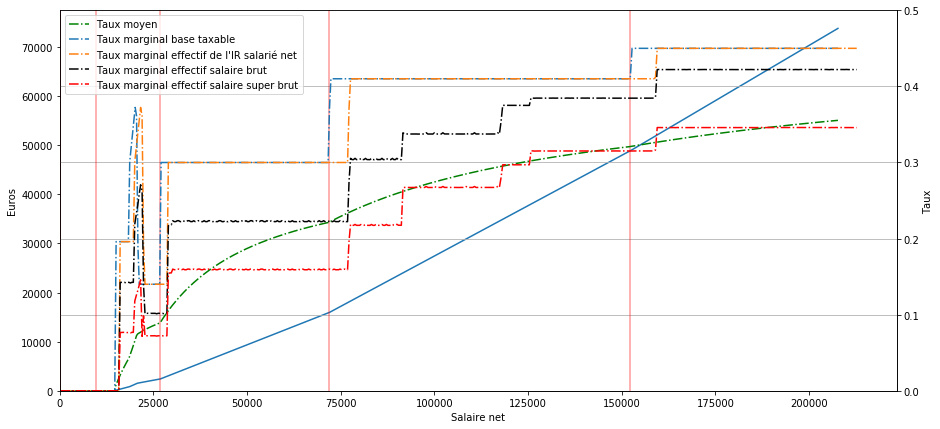

In [79]:
fig = plt.figure(figsize=(15,7))
smooth = 2
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        impot_total_sur_le_revenu, label = 'Impot')
ax2.plot(rni,
        1-rates.average_rate(
                           impot_total_sur_le_revenu,rni), linestyle = "-.", color = "g", label = "Taux moyen")

ax2.plot(rni[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,rni)[::smooth], linestyle = "-.", label = "Taux marginal base taxable")
ax2.plot(salaire_net[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,rni)[::smooth], linestyle = "-.", label = u"Taux marginal effectif de l'IR salarié net")
ax2.plot(salaire_net[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,salaire_de_base)[::smooth], linestyle = "-.", color = "k", label = "Taux marginal effectif salaire brut")
ax2.plot(salaire_net[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,salaire_super_brut)[::smooth], linestyle = "-.", color = "r", label = "Taux marginal effectif salaire super brut")

for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5); plt.legend(); plt.grid(); ax.set_xlabel("Salaire net"); ax2.set_ylabel("Taux") ; ax.set_ylabel("Euros")

Text(0,0.5,'Euros')

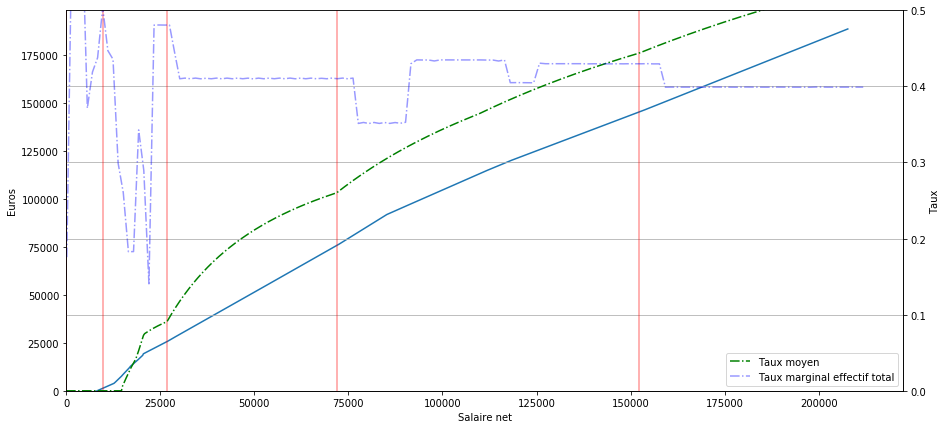

In [80]:
fig = plt.figure(figsize=(15,7))
smooth = 7
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        salaire_super_brut- revenu_disponible, label = 'Impot total')
ax2.plot(rni,
        1-rates.average_rate(
                           impot_total_sur_le_revenu,revenu_disponible), linestyle = "-.", color = "g", label = "Taux moyen")

ax2.plot(salaire_net[1::smooth],
        1-rates.marginal_rate(
                           revenu_disponible,salaire_super_brut)[::smooth], linestyle = "-.", color = "b", label = "Taux marginal effectif total", alpha = 0.4)


for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5); plt.legend(); plt.grid(); ax.set_xlabel("Salaire net"); ax2.set_ylabel("Taux") ; ax.set_ylabel("Euros")

TODO: comment

In [81]:
def switch_foyer_sum_to_menage(simulation, variable):
    computed_variable = simulation.calculate(variable, period = "2016")
    projected_variable =  simulation.foyer_fiscal.project_on_first_person(computed_variable)
    summed_over_menage_variable = simulation.menage.sum(projected_variable)
    return summed_over_menage_variable

## Gain fiscal au mariage

Un menage composé d'un couple sans enfant devrait payer le même impôt que la somme des deux célibataires ayant le même salaire, vérifions celà... 

In [82]:
simulation_single = make_scenario(couple = False, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000, salaire_de_base_conjoint=0).new_simulation()
simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000, salaire_de_base_conjoint=0).new_simulation()
simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000, salaire_de_base_conjoint=0).new_simulation()

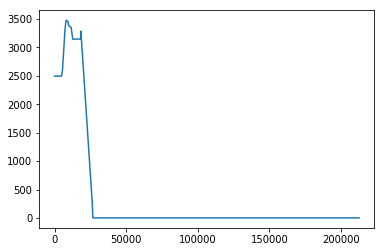

In [83]:
salaire_net = simulation_single.calculate_add("salaire_net", 2016)
plt.plot( salaire_net,
         simulation_couple.calculate("revenu_disponible", period = 2016) - simulation_single.calculate("revenu_disponible", period = 2016))

On voit bien qu'a l'exception des minimums sociaux qui dépendent de la structure du ménage, le revenu disponible est le même quand on sort de ces minimums. L'impôt est donc neutre entre les couples sans unions civile et les célibataires.

Pourtant il y a un gain notable à se marier ou se pacser dans le cadre des couples monoactifs (avec ou sans enfants), en effet le revenu mis au barème sera divisé par deux.

Text(0,0.5,'Ga')

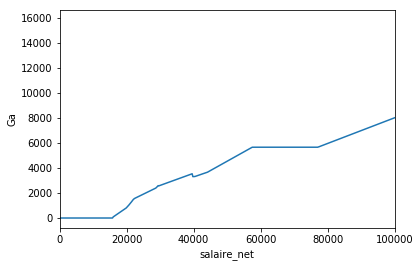

In [85]:
plt.figure()
plt.plot( salaire_net
    ,simulation_couple_marpacs.calculate("revenu_disponible", period = 2016) -simulation_couple.calculate("revenu_disponible", period = 2016) )
plt.xlim(0,10**5); plt.xlabel("salaire_net") ; plt.ylabel("Ga")

On peut également voir l'évolution de ce gain en fonction des années et des changement dans le barème.

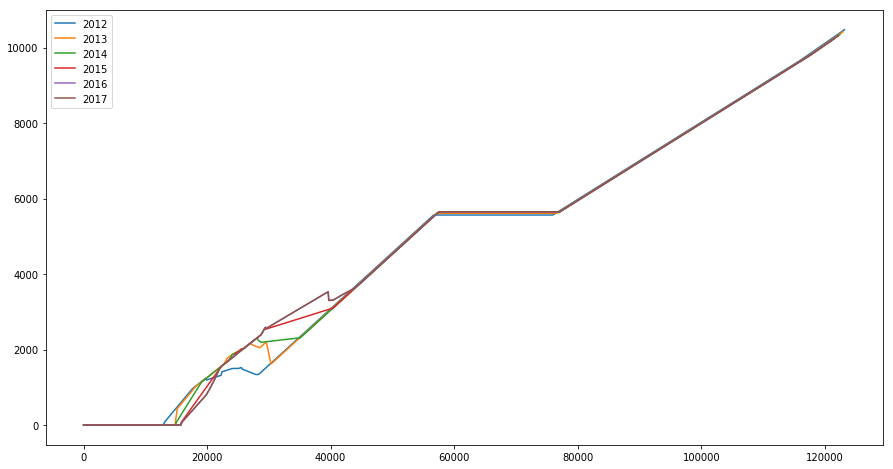

In [86]:
plt.figure(figsize=(15,8))
for year in range(2012,2018):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=150000, salaire_de_base_conjoint=0).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=150000, salaire_de_base_conjoint=0).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", year)
    plt.plot( salaire_net[::2],
    simulation_couple_marpacs.calculate("revenu_disponible", period = year) -simulation_couple.calculate("revenu_disponible", period = year), label = year )
plt.legend()

(15000, 50000)

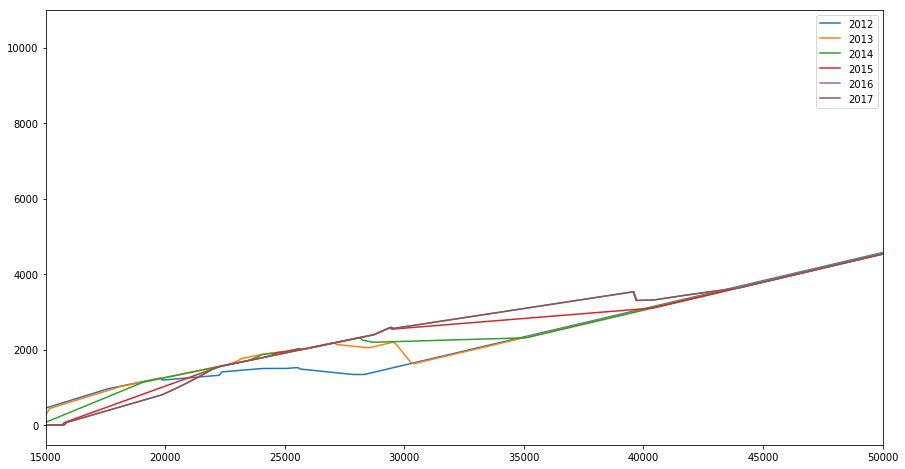

In [87]:
%matplotlib inline
plt.figure(figsize=(15,8))
for year in range(2012,2018):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=150000, salaire_de_base_conjoint=0).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=150000, salaire_de_base_conjoint=0).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", year)
    plt.plot( salaire_net[::2],
    simulation_couple_marpacs.calculate("revenu_disponible", period = year) -simulation_couple.calculate("revenu_disponible", period = year), label = year )
plt.legend(); plt.xlim(15000, 50000)

In [88]:
simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=15000, ax_variable_max=30000, salaire_de_base_conjoint=25000, count = 10).new_simulation()
simulation_couple.calculate("ip_net", 2016)
simulation_couple.calculate_add("salaire_net", 2016)

array([11676.004, 19460.002, 12973.339, 19460.002, 14270.667, 19460.002,
       15568.003, 19460.002, 16865.34 , 19460.002, 18162.664, 19460.002,
       19460.002, 19460.002, 20757.338, 19460.002, 22054.66 , 19460.002,
       23352.   , 19460.002], dtype=float32)

CPU times: user 48.4 s, sys: 722 ms, total: 49.2 s
Wall time: 49.8 s


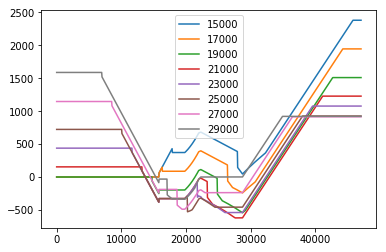

In [38]:
%%time
for salaire_de_base_conjoint in xrange(15000,30000, 2000):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", 2016)[::2]
    plt.plot(salaire_net, simulation_couple_marpacs.calculate("revenu_disponible", period = 2016) -simulation_couple.calculate("revenu_disponible", period = 2016),
             label= salaire_de_base_conjoint )
plt.legend()

CPU times: user 47.8 s, sys: 792 ms, total: 48.6 s
Wall time: 49.6 s


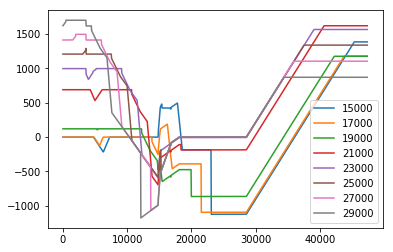

In [39]:
%%time
for salaire_de_base_conjoint in xrange(15000,30000, 2000):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2013, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = 2013, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", 2013)[::2]
    plt.plot(salaire_net, simulation_couple_marpacs.calculate("revenu_disponible", period = 2013) -simulation_couple.calculate("revenu_disponible", period = 2013),
             label= salaire_de_base_conjoint )
plt.legend()

CPU times: user 45.4 s, sys: 604 ms, total: 46 s
Wall time: 46.4 s


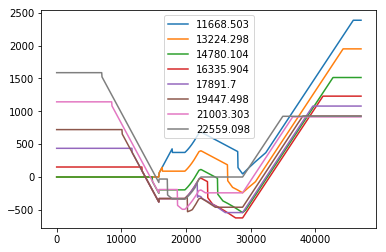

In [40]:
%%time
year = 2017
for salaire_de_base_conjoint in xrange(15000,30000, 2000):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", year)
    plt.plot(salaire_net[::2], simulation_couple_marpacs.calculate("revenu_disponible", period = year) -simulation_couple.calculate("revenu_disponible", period = year),
             label= salaire_net[1] )
plt.legend()

In [89]:
#%matplotlib notebook

### Evolution de la perte chaque année

In [106]:
#%%time
#plt.figure(figsize=(12,6))
#for year in [2013,2015,2017]:
#
#    for salaire_de_base_conjoint in xrange(15000,30000, 2000):
#    
#        simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
#        simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
#        salaire_net = simulation_couple.calculate_add("salaire_net", year)
#        plt.plot(salaire_net[::2], simulation_couple_marpacs.calculate("revenu_disponible", period = year) -simulation_couple.calculate("revenu_disponible", period = year),
#                 label= salaire_net[1] )
#        plt.show()
#plt.legend()

Heatmap à la Allègre 2014 (ou the Gitlab like heatmap.).

In [91]:
import seaborn as sns

In [101]:
%%time
count = 1000
plt.figure(figsize=(12,6))
for year in [2017]:

    for salaire_de_base_conjoint in xrange(0,60000, 2000):
        
        simulation_couple = make_scenario(couple = True, mar_pacs=False,  count = count, nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
        simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True, count = count, nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
        salaire_net_1 = simulation_couple.calculate_add("salaire_net", year)[::2]
        salaire_net_2 = simulation_couple.calculate_add("salaire_net", year)[1]
        if salaire_de_base_conjoint ==0: 
            df_heatmap = pd.DataFrame(columns=salaire_net_1)
        gain_mariage =  simulation_couple_marpacs.calculate("revenu_disponible", period = year) -simulation_couple.calculate("revenu_disponible", period = year)
        df_heatmap.loc[salaire_net_2] = gain_mariage
        


CPU times: user 3min 2s, sys: 2.16 s, total: 3min 4s
Wall time: 3min 9s


<Figure size 864x432 with 0 Axes>

In [102]:
df_heatmap.sort_index(ascending=False, inplace = True)

In [103]:
df_heatmap.min().min()

-692.72656

In [104]:
df_heatmap.max().max()

4090.1797

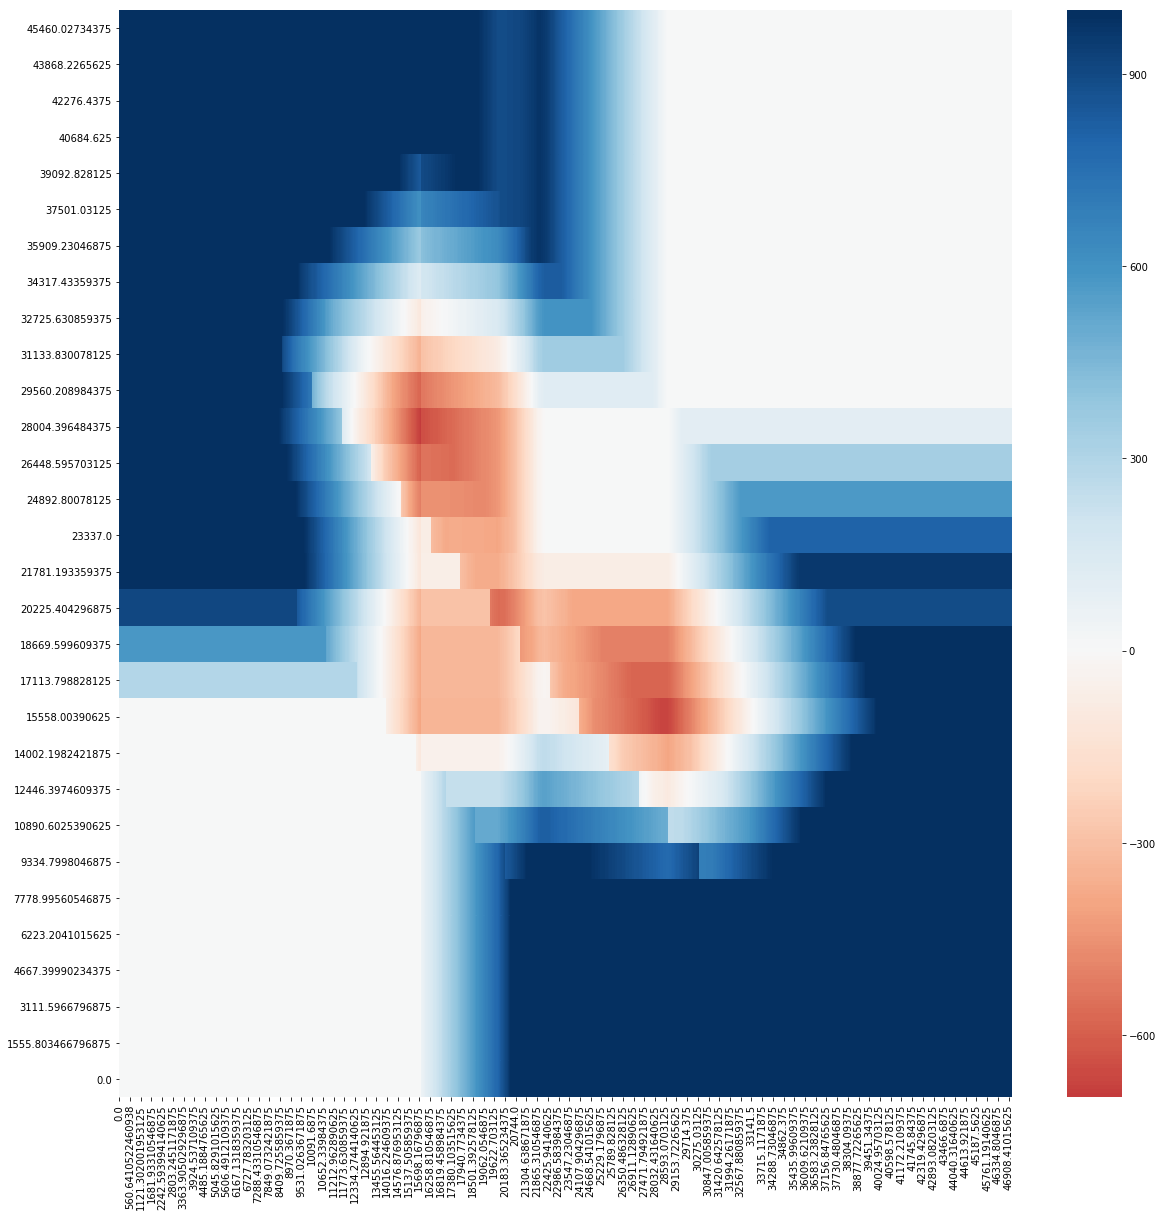

In [105]:
plt.figure(figsize = (20,20))
sns.heatmap(df_heatmap,center=0, cmap="RdBu", vmin = -697, vmax = 1000)
